# LiCl ion pair dissociation in water
This notebook will show you how to setup a keras SNN and do some ANN assisted TPS with full atomistic inputs on a system in which the solvent plays an important role.

In [1]:
# to be able tu run multiple notebooks in paralell:
# tell tf to not grab the whole GPU memory available
import tensorflow as tf
if tf.version.VERSION.startswith('2.'):
    # tell tf to use only the GPU mem it needs
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print('available GPUs: ', gpus)
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    from tensorflow.keras import backend as K

else:
    conf = tf.compat.v1.ConfigProto()
    conf.gpu_options.allow_growth = True
    conf.gpu_options.per_process_gpu_memory_fraction = 0.25
    #tf.enable_eager_execution(config=conf)\n",
    sess = tf.compat.v1.Session(config=conf)
    from tensorflow.keras import backend as K
    K.set_session(sess)

available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Basic imports
%matplotlib inline
import aimmd
import os
import openpathsampling as paths
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 9, 6  # make the figures a bit bigger
import openpathsampling.engines.openmm as peng_omm
from simtk.openmm import app
import simtk.openmm as mm
import simtk.unit as unit
from openmmtools.integrators import VVVRIntegrator
import mdtraj as md

In [3]:
# get the logging running
%run ../resources/logconf.py

wdir = '/home/tb/hejung/DATA/aimmd_scratch/SimData_keras_SNN_LiCl/'
#wdir = None
cur_dir = os.path.abspath(os.getcwd())
if wdir is not None:
    if not os.path.isdir(wdir):
        os.mkdir(wdir)
    os.chdir(wdir)

import logging.config
logging.config.dictConfig(LOGCONFIG)

In [4]:
# setup openMM integrator and system
forcefield = app.ForceField(os.path.join(cur_dir, 'forcefield/tip3p_standard.xml'))
pdb = app.PDBFile(os.path.join(cur_dir, 'LiCl_solv.pdb'))
system = forcefield.createSystem(
    pdb.topology, 
    nonbondedMethod=app.PME, 
    nonbondedCutoff=1.0*unit.nanometers,
    constraints=app.HBonds, 
    rigidWater=True,
    ewaldErrorTolerance=0.0005
)
integrator = VVVRIntegrator(
    300*unit.kelvin, 
    1.0/unit.picoseconds, 
    2.0*unit.femtoseconds)
integrator.setConstraintTolerance(0.00001)

template = peng_omm.snapshot_from_pdb(os.path.join(cur_dir, 'LiCl_solv.pdb'))
#openmm_properties = {'OpenCLPrecision': 'mixed'}
engine_options = {
    'n_frames_max': 25000,
    'nsteps_per_frame': 10
                  }
engine = peng_omm.Engine(template.topology,
                         system,
                         integrator,
                         #openmm_properties=openmm_properties,
                         options=engine_options
                         )
engine.name = '300K'

In [5]:
# load initial TP for ala (generated at high temp, 400K)
# we load the h5py trajectory and define the states from scratch
# for better machine interoperability and smaller footprint in repo
initialTP_md = md.load(os.path.join(cur_dir, 'initial_TP_400K.h5'))
initialTP = peng_omm.trajectory_from_mdtraj(initialTP_md)
template = peng_omm.snapshot_from_pdb(os.path.join(cur_dir, "LiCl_solv.pdb"))

# define the CV
ion_dist = paths.MDTrajFunctionCV("ion_dist", md.compute_distances, template.topology, atom_pairs=[[0, 1]])

# define the states
bound = (paths.CVDefinedVolume(ion_dist, lambda_min=0.01, lambda_max=0.23)).named("bound")
# similarly, without bothering with the labels:
unbound = (paths.CVDefinedVolume(ion_dist, .48, 1.0)).named("unbound")

In [6]:
tps = paths.TPSNetwork.from_states_all_to_all([bound, unbound])

# do aimmd stuff:
- create coordinate transformation function
- create model
- create wrapper object and trainset
- then the OPS interaction: selector and training hook

In [7]:
## symmetry functions and internal coordinates
# fine tuned after plots in plot_symmetry_funcs notebook
# but we take some more symmetry funcs for the cluster
cutoff = 1. # consider G5 worst case scenarios for cutoff!
g2_parms = [[200., 0.25], [200., 0.4], [200., 0.55], [200., 0.7], [200., 0.85]] # eta, r_s

g5_etas_rs = [[120., 0.25],
              [120., 0.4],
              [120., 0.55],
              [120., 0.7],
              [120., 0.85]
             ]

zetas = [
        1,
        2,
        4,
        16,
        64,
        ]

g5_parms = [[eta, r_s, zeta, lamb] for (eta, r_s) in g5_etas_rs for zeta in zetas for lamb in [+1., -1.]]

g_parms = [g2_parms, g5_parms]

mol_idxs, solv_idxs = aimmd.coords.symmetry.generate_indices(template.topology.mdtraj,
                                                            ['HOH'],
                                                            solvent_atelements=[['O', 'H']],
                                                            reactant_selection='index 0 or index 1')

sf_parms = {'mol_idxs': mol_idxs, 'solv_idxs': solv_idxs, 'g_parms': g_parms,
            'cutoff': cutoff, 'n_per_solv': [[1., 2.]], 'rho_solv': [33.]}

sf_transform = paths.MDTrajFunctionCV('sf_transform', aimmd.coords.symmetry.transform,
                               template.topology, **sf_parms)


ic_parms = {}
custom_cv_func = md.compute_distances
dist_atom_indices = np.array([[0, 1]])


def transform_func(mdtra, sf_parms, dist_atom_indices):
    import mdtraj as md
    from aimmd.coords.symmetry import sf
    import numpy as np
    return np.concatenate([sf(mdtra, **sf_parms),
                           md.compute_distances(mdtra, dist_atom_indices)],
                          axis=1)
    

descriptor_transform = paths.MDTrajFunctionCV('descriptor_transform', transform_func,
                                              template.topology, sf_parms=sf_parms, 
                                              dist_atom_indices=dist_atom_indices,
                                              cv_scalarize_numpy_singletons=False)


number of descriptors:  221


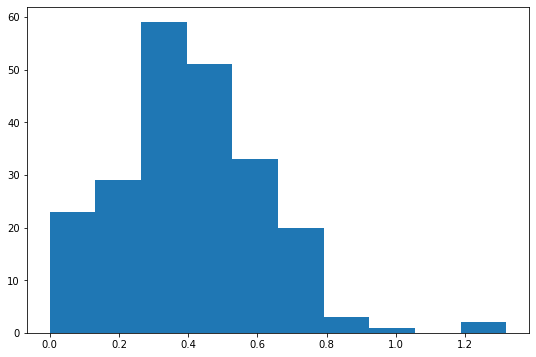

In [8]:
# get number of descriptors and have a look at the histo of values
trans_coords = descriptor_transform(template)
cv_ndim = trans_coords.shape[0]
plt.hist(trans_coords);
print('number of descriptors: ', cv_ndim)

In [10]:
from tensorflow.keras import optimizers, regularizers

In [12]:
hidden_parms = [{'units_factor': 1,
                 'activation': 'selu',
                 'use_bias': True,
                 'kernel_initializer': 'lecun_normal',
                 'bias_initializer': 'lecun_normal',
                 'kernel_regularizer': None,#regularizers.l1(l=0.00001),#regularizers.l1(),
                 'bias_regularizer': None,#regularizers.l1(),
                 'activity_regularizer':None,
                 'kernel_constraint':None,
                 'bias_constraint':None,
                 'dropout': 0.05,
                }]
hidden_parms = [{'units_factor': 0.3,
                 'activation': 'selu',
                 'use_bias': True,
                 'kernel_initializer': 'lecun_normal',
                 'bias_initializer': 'lecun_normal',
                 'kernel_regularizer': None,#regularizers.l1(l=0.00001),#regularizers.l1(),
                 'bias_regularizer': None,#regularizers.l1(),
                 'activity_regularizer':None,
                 'kernel_constraint':None,
                 'bias_constraint':None,
                 'dropout': 0.01,
                }
                for i in range(1,4)]
hidden_parms += [{'units_factor': 0.3,
                 'activation': 'selu',
                 'use_bias': True,
                 'kernel_initializer': 'lecun_normal',
                 'bias_initializer': 'lecun_normal',
                 'kernel_regularizer': None, #regularizers.l1(l=0.0001),
                 'bias_regularizer': None,#regularizers.l2(),
                 'activity_regularizer':None,
                 'kernel_constraint':None,
                 'bias_constraint':None,
                 'dropout': 0.1}]
optimizer = optimizers.Adam(lr=1e-4)
# create a SNN with binomial loss to predict p_B
snn = aimmd.keras.create_snn(ndim=cv_ndim, hidden_parms=hidden_parms,
                             optimizer=optimizer, n_states=2,  # does not really matter if multi_state=False
                             multi_state=False)

In [13]:
aimmd_store = aimmd.Storage(os.path.join(wdir, 'aimmd_storage.h5'), mode='w')

In [15]:
model = aimmd.keras.EEScaleKerasRCModel(nnet=snn,
                                        states=[bound, unbound],
                                        descriptor_transform=descriptor_transform,
                                        cache_file=aimmd_store,
                                        ee_params={'lr_0': 1e-4, 'lr_min': 1e-6, 'epochs_per_train': 5, 'interval': 5, 'window': 100}
                                       )

In [16]:
# create a trainset
trainset = aimmd.TrainSet(n_states=2)

In [17]:
trainhook = aimmd.ops.TrainingHook(model, trainset)
storehook = aimmd.ops.AimmdStorageHook(aimmd_store, model, trainset)
densityhook = aimmd.ops.DensityCollectionHook(model, interval=20, first_collection=100)

In [18]:
selector = aimmd.ops.RCModelSelector(model, [bound, unbound])

In [19]:
move_scheme = paths.MoveScheme(network=tps)
beta = 1. / (integrator.getTemperature() * unit.BOLTZMANN_CONSTANT_kB)
modifier = paths.RandomVelocities(beta=beta, engine=engine)
tw_strategy = paths.strategies.TwoWayShootingStrategy(modifier=modifier, selector=selector, engine=engine, group='TwoWayShooting')
move_scheme.append(tw_strategy)
move_scheme.append(paths.strategies.OrganizeByMoveGroupStrategy())
move_scheme.build_move_decision_tree()

In [20]:
initial_conditions = move_scheme.initial_conditions_from_trajectories(initialTP)

No missing ensembles.
No extra ensembles.


In [21]:
storage = paths.Storage('LiCl_snn_full_SFs.nc', 'w', template=template)

In [22]:
sampler = paths.PathSampling(storage=storage, sample_set=initial_conditions, move_scheme=move_scheme)

In [23]:
# attach the hooks
sampler.attach_hook(trainhook)
sampler.attach_hook(storehook)
sampler.attach_hook(densityhook)

In [25]:
sampler.run(5000)

Working on Monte Carlo cycle number 5000
Running for 4 hours 33 minutes 15 seconds -  6.56 seconds per step
Estimated time remaining: 6 seconds
DONE! Completed 5000 Monte Carlo cycles.


## The usual look at the training process

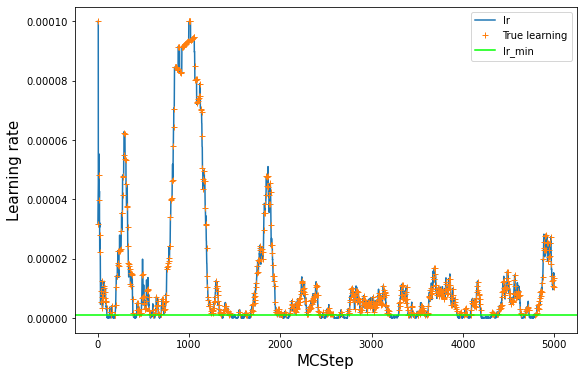

In [26]:
# lets have a look at the value of the learning rate over the course of training
# note however, that we did not train at every step, but just at every interval MCsteps
log_train = np.array(model.log_train_decision)
lr = log_train[:,1]
plt.plot(lr, label='lr')
# see where we really trained: everywhere where train=True
# set lr_true to NaN anywhere where we did not train to have a nice plot
lr_true = lr
lr_true[log_train[:,0] == False] = np.nan
plt.plot(lr_true, '+', label='True learning')
# lr_min as a guide to the eye
plt.axhline(model.ee_params['lr_min'], label='lr_min', color='lime')
plt.legend()
plt.xlabel('MCStep', size=15);
plt.ylabel('Learning rate', size=15);

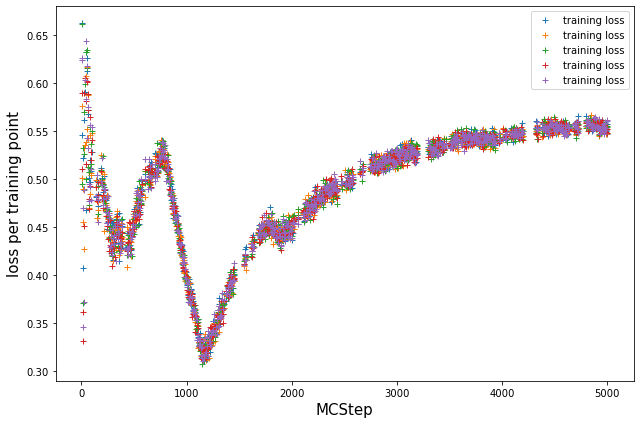

In [27]:
# resort such that we have a loss value per MCStep, NaN if we did not train at that step
train_loss = []
count = 0
for t in log_train[:, 0]:
    if t:
        train_loss.append(model.log_train_loss[count])
        count += 1
    else:
        train_loss.append([np.nan for _ in range(model.ee_params['epochs_per_train'])])
    
plt.plot(train_loss, '+', label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('MCStep', size=15)
plt.tight_layout()

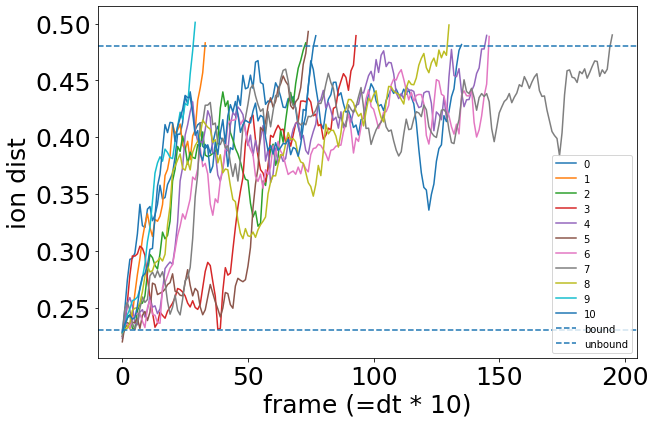

In [28]:
# plot some trajectories projected onto the ion dist CV
ion_dist = storage.cvs.find('ion_dist')
bound = storage.volumes.find('bound')
unbound = storage.volumes.find('unbound')
tras = []
tras_ops = []
for step in storage.steps[-50:]:
    if step.change.canonical.accepted:
        if bound(step.change.canonical.trials[0].trajectory[0]):
            tras.append(ion_dist(step.change.canonical.trials[0].trajectory))
            tras_ops.append(step.change.canonical.trials[0].trajectory)
        else:
            # append reversed tra
            tras.append(ion_dist(step.change.canonical.trials[0].trajectory.reversed))
            tras_ops.append(step.change.canonical.trials[0].trajectory.reversed)
#tras.append(ion_dist(storage.trajectories[-1]))
#tras.append(ion_dist(storage.trajectories[-10]))

for i, tra in enumerate(tras):
    plt.plot(np.arange(len(tra)), tra, label=i)

plt.axhline(bound.lambda_max, linestyle='--', label='bound')
plt.axhline(unbound.lambda_min, linestyle='--', label='unbound')
plt.xlabel('frame (=dt * 10)', size=25)
plt.ylabel('ion dist', size=25)
plt.tick_params(labelsize=25)
#plt.ylim(0., 1.)
plt.legend()
plt.tight_layout()

In [29]:
accepts = []
for step in storage.steps:
    if step.change.canonical.accepted:
        accepts.append(1.)
    else:
        accepts.append(0.)

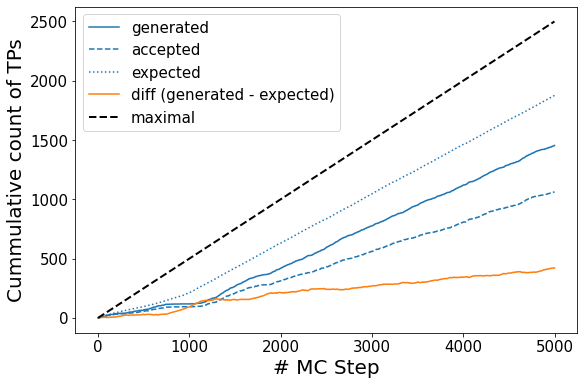

In [30]:
p_ex = np.array(model.expected_p)

l, = plt.plot(np.cumsum(trainset.transitions), label='generated');
plt.plot(np.cumsum(accepts), c=l.get_color(), ls='--', label='accepted');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex)),c=l.get_color(), ls=':', label='expected');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex))- np.cumsum(trainset.transitions), label='diff (generated - expected)')
plt.plot(np.linspace(0., len(trainset)/2., len(trainset)), c='k', ls='--', label='maximal', lw=2)
plt.legend(fontsize=15);
plt.tick_params(labelsize=15)
plt.ylabel('Cummulative count of TPs', size=20)
plt.xlabel('# MC Step', size=20);

## HIPR

In [31]:
hipr = aimmd.analysis.HIPRanalysis(model, trainset)

In [33]:
hipr_plus_losses, hipr_plus_stds = hipr.do_hipr_plus(25)

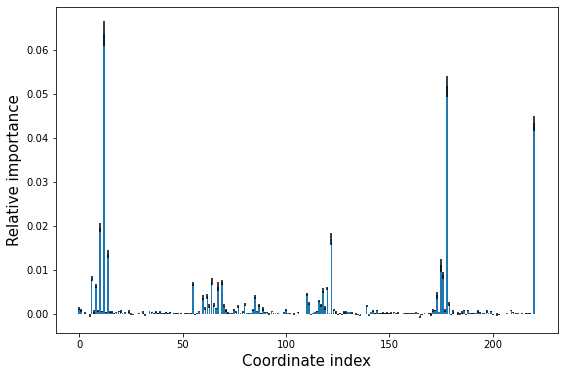

In [35]:
loss_diffs = hipr_plus_losses[:-1] - hipr_plus_losses[-1]  # hipr_plus_losses[-1] is the reference loss over the unaltered trainset

plt.bar(np.arange(len(loss_diffs)), loss_diffs, yerr=hipr_plus_stds[:-1])
plt.xlabel('Coordinate index', size=15)
plt.ylabel('Relative importance', size=15);

In [37]:
# what are the most important contributors?
max_idxs = np.argsort(loss_diffs)[::-1]
sf_parms = descriptor_transform.kwargs['sf_parms']

print('reference loss:', hipr_plus_losses[-1])
for idx in max_idxs[:20]:
    print()
    print('loss for idx {:d}: '.format(idx), hipr_plus_losses[idx])
    print(aimmd.coords.get_involved(idx, sf_parms=sf_parms, solvent_atoms=[['O', 'H']], solvent_resname=['HOH']))

reference loss: 0.48755019903182983

loss for idx 12:  0.5511265659332275
('SF', ('G5', [120.0, 0.25, 16, -1.0], 0, 'HOH', 'O'))

loss for idx 178:  0.539182367324829
('SF', ('G5', [120.0, 0.25, 64, 1.0], 1, 'HOH', 'H'))

loss for idx 220:  0.5307720851898193
('CustomCV', 0)

loss for idx 10:  0.5071001315116882
('SF', ('G5', [120.0, 0.25, 4, -1.0], 0, 'HOH', 'O'))

loss for idx 122:  0.5044933271408081
('SF', ('G5', [120.0, 0.25, 16, -1.0], 0, 'HOH', 'H'))

loss for idx 14:  0.5011527407169342
('SF', ('G5', [120.0, 0.25, 64, -1.0], 0, 'HOH', 'O'))

loss for idx 175:  0.4984957480430603
('SF', ('G5', [120.0, 0.25, 4, -1.0], 1, 'HOH', 'H'))

loss for idx 176:  0.49621764302253724
('SF', ('G5', [120.0, 0.25, 16, 1.0], 1, 'HOH', 'H'))

loss for idx 6:  0.4955493891239166
('SF', ('G5', [120.0, 0.25, 1, -1.0], 0, 'HOH', 'O'))

loss for idx 64:  0.4948109459877014
('SF', ('G5', [120.0, 0.25, 4, 1.0], 1, 'HOH', 'O'))

loss for idx 69:  0.49463404893875124
('SF', ('G5', [120.0, 0.25, 64, -1.0]

## Movie

In [32]:
from aimmd.analysis import GradientMovieMaker

In [33]:
gmovie = GradientMovieMaker(trainhook.model, trainhook.model.descriptor_transform, storage.snapshots[-3].topology.mdtraj)

In [34]:
step = storage.steps[-3]
shot_snap = step.change.canonical.details.shooting_snapshot

In [35]:
# get indices of water around lithium and chloride
atom_indices = list(md.compute_neighbors(paths.Trajectory([shot_snap]).to_mdtraj(),
                                         trainhook.model.descriptor_transform.kwargs['sf_parms']['cutoff'],
                                         query_indices=trainhook.model.descriptor_transform.kwargs['sf_parms']['mol_idxs'],
                                         haystack_indices=np.concatenate(trainhook.model.descriptor_transform.kwargs['sf_parms']['solv_idxs'][0]))[0])
atom_indices += [0, 1]  # add the lithium and the chloride to gradient calculations
atom_indices = np.array(atom_indices)

In [37]:
mols = gmovie.topology.find_molecules()
anchor_mols = mols[0:2]
print(mols[0:2])

In [38]:
# make a gradient direction movie around the 3rd last shooting point
gmovie.movie_around_snapshot(shot_snap, 'gradient_movie.pdb', atom_indices=atom_indices, anchor_mols=anchor_mols)

In [29]:
# or make a gradient colored pdb trajectory of a TP
# lets take one of the TP trajectories we plotted above
# best take a short one...the moviemaking takes quite a while...
print([len(t) for t in tras_ops])

[84, 59, 55, 29, 44, 57, 49, 134]


In [41]:
gmovie.color_by_gradient(tras_ops[np.argmin([len(t) for t in tras_ops])], 'TP_colored_by_gradient.pdb', atom_indices=atom_indices, anchor_mols=anchor_mols)

In [38]:
storage.sync_all()
storage.close()

In [39]:
aimmd_store.close()